# LAB 4: Topic modeling

Use topic models to explore hotel reviews

Objectives:

- tokenize with MWEs using spacy
- estimate LDA topic models with tomotopy
- visualize and evaluate topic models
- apply topic models to interpretation of hotel reviews

In [1]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

tqdm.pandas()

## Load and prepare review texts

In [2]:
df = pd.read_pickle("/data/hotels_id.pkl")

Select a sample of reviews to work with (replace x's below with the sample size; you should use at least 50,000 reviews)

In [3]:
df = df.sample( )

Tokenize reviews

In [4]:
from tokenizer import MWETokenizer

tokenizer = MWETokenizer(t.strip() for t in open("terms.txt"))

In [5]:
df["tokens"] = list((df["title"] + " " + df["text"]).progress_apply(tokenizer.tokenize))

  0%|          | 0/10000 [00:00<?, ?it/s]

## Estimate LDA

In [6]:
import tomotopy as tp

These are the model **hyperparameters**: aspects of the model that aren't estimated from the data but have to be set in advance by the analyst. There's no "right" values for these. You'll just have to try out different values to find settings that give you a model that you can interpret:

- _k_ = number of topics
- _min_df_ = minimum number of reviews that a term has to occur in to be included in the model
- _rm_top_ = number of most frequent terms to remove from the model
- _tw_ = term weighting strategy (described [here](https://bab2min.github.io/tomotopy/v0.10.1/en/#tomotopy.TermWeight))
- _alpha, eta_ = priors for document-topic and topic-word distributions
- _tol_ = convergence tolerance

In [7]:
k = 50
min_df = 100
rm_top = 100
tw = tp.TermWeight.ONE
alpha = 0.1
eta = 0.01
tol = 1e-4

Here's where we do the work. The documentation for `LDAModel` is [here](https://bab2min.github.io/tomotopy/v0.10.1/en/#tomotopy.LDAModel). You might also consider trying out one of the other model types (e.g., `HDPModel`).

In [8]:
%%time

mdl = tp.LDAModel(k=k, min_df=min_df, rm_top=rm_top, tw=tw, alpha=alpha, eta=eta)

for doc in df["tokens"]:
    if doc:
        mdl.add_doc(doc)

mdl.train(0)
last = mdl.ll_per_word
print(f"{0:5d} LL = {last:8.4f}", flush=True)

for i in range(50, 5000, 50):
    mdl.train(50, workers=4)
    ll = mdl.ll_per_word
    print(f"{i:5d} LL = {ll:8.4f}", flush=True)
    if ll - last < tol:
        break
    else:
        last = ll

print(f"Done!")

    0 LL = -11.8247
   50 LL =  -8.0693
  100 LL =  -7.9216
  150 LL =  -7.8494
  200 LL =  -7.8044
  250 LL =  -7.7772
  300 LL =  -7.7604
  350 LL =  -7.7537
  400 LL =  -7.7473
  450 LL =  -7.7372
  500 LL =  -7.7375
Done!
CPU times: user 34.3 s, sys: 512 ms, total: 34.8 s
Wall time: 13.3 s


## Examine the model

Which terms got removed due to `rm_top`? If any of these look like they might be relevant to hotel reviews, then `rm_top` is probably too big.

In [9]:
", ".join(mdl.removed_top_words)

"the, and, a, to, was, i, in, we, of, is, for, it, not, hotel, at, room, but, were, that, with, this, on, very, you, had, there, have, our, my, are, they, from, as, stay, so, would, be, all, do, 's, if, one, rooms, staff, out, stayed, no, us, an, nice, when, which, clean, great, just, or, location, here, about, up, get, could, will, night, good, can, also, again, me, only, $, by, well, like, did, really, friendly, service, back, comfortable, some, small, more, breakfast, what, helpful, even, after, your, day, two, time, place, bathroom, than, been, 2, area, has, got"

Use LDAvis algorithm to plot. We'd like to see topics evenly spread out in space without too much overlap.

In [10]:
import matplotlib.pyplot as plt
from scipy.spatial import distance
from sklearn.manifold import MDS, TSNE


def plot_topics(mdl, method="tsne", figsize=7):

    fig = plt.figure(figsize=(figsize, figsize))

    # x, y coords
    term_topics_dist = np.stack([mdl.get_topic_word_dist(k) for k in range(mdl.k)])
    if method == "mds":
        dist = distance.squareform(distance.pdist(term_topics_dist, "jensenshannon"))
        coords = MDS(2, dissimilarity="precomputed").fit_transform(dist)
    elif method == "tsne":
        if mdl.k <= 20:
            p = mdl.k - 1
        else:
            p = 20
        coords = TSNE(
            2,
            metric=distance.jensenshannon,
            perplexity=p,
            init="pca",
            learning_rate="auto",
            n_jobs=-1,
        ).fit_transform(term_topics_dist)
    else:
        raise ValueError(f"Method {method} unknown")

    # size of the circle
    doc_topic_dists = np.stack([doc.get_topic_dist() for doc in mdl.docs])
    doc_lengths = np.array([len(doc.words) for doc in mdl.docs])
    words_per_topic = np.dot(doc_topic_dists.T, doc_lengths)
    topic_percent = words_per_topic / words_per_topic.sum()
    sizes = topic_percent * (figsize * fig.dpi) * (figsize * fig.dpi) * (0.25 / 3.14)

    # draw it
    plt.scatter(coords[:, 0], coords[:, 1], s=sizes, alpha=0.3)
    for i in range(mdl.k):
        plt.text(coords[i, 0], coords[i, 1], i, ha="center", va="center")

        plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

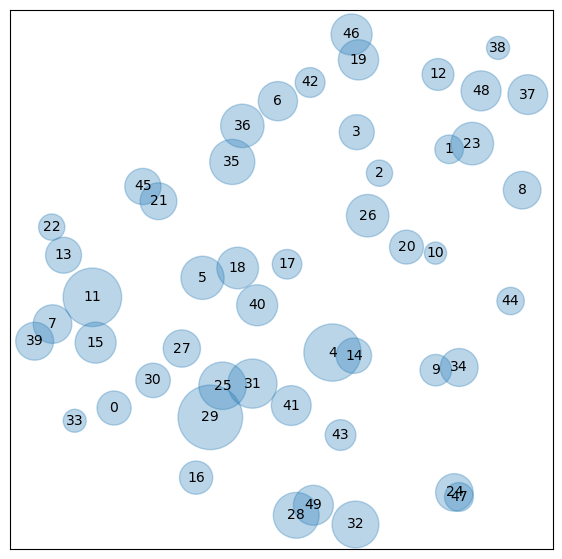

In [11]:
plot_topics(mdl)

## Interpret the model

What terms are associated with each topic? = $p(w|z)$

In [12]:
for k in range(mdl.k):
    print(f"{k:3d} ", ", ".join(s for s, _ in mdl.get_topic_words(k)))

  0  booked, through, rate, priceline, their, paid, because, website, reservation, price
  1  close, dc, metro, priced, located, reasonably, restaurants, found, near, eat
  2  conference, business, convention, food, convention_center, meeting, while, event, attending, group
  3  seattle, decorated, nicely, excellent, large, quiet, lobby, appointed, pleasant, enjoyed
  4  little, though, quite, bit, overall, bed, although, lobby, modern, much
  5  elevator, elevators, use, work, internet, slow, any, problem, floor, issue
  6  best, ever, amazing, most, beautiful, experience, fantastic, wonderful, loved, love
  7  minutes, check, arrived, ready, took, wait, front_desk, 10, 15, called
  8  street, across, right, down, noise, next_door, road, next, great_location, bit
  9  money, price, motel, value, worth, great_value, budget, close, basic, looking
 10  san_diego, beach, la, hollywood, pool, balcony, bay, parking, view, sheraton
 11  down, front_desk, called, never, another, told, went, c

Which documents best reflect each topic?

In [13]:
import textwrap


def print_topic_docs(topic, n_best=3):
    topic_weights = sorted(
        [(doc.get_topic_dist()[topic], i) for i, doc in enumerate(mdl.docs)],
        reverse=True,
    )
    for i in range(n_best):
        print(
            textwrap.indent(
                textwrap.fill(df["text"].iloc[topic_weights[i][1]], width=100), "  "
            )
        )
        print()

In [14]:
print_topic_docs(0)

  Be careful when booking a reservation on HolidayInn.com. The reservations labeled "Book Early and
  Save" are non-refundable reservations. I spoke with the hotel manager and he would not refund the
  reservation, even though I called in immediately after the reservation was made. I did not expect
  this type of service from an established hotel. In addition, the website is very misleading when it
  comes to non-refundable rates. Be careful when you're booking online and don't get screwed like I
  did. I won't be returning to the hotel anytime soon.

  I attempted to stay at this hotel through a rate purchased through an online agency. The person at
  the front desk was clueless and slow; and, in the end, was unable to find my reservation.
  Additionally, the lobby reeked of stale beer. If you're booking through an online service, beware;
  they're happy to lose your reservation and share in the revenue with the agency.

  Booked thru Priceline for $110/night. Called hotel to request 

In [15]:
for topic in range(mdl.k):
    print(f"Topic = {topic} ({', '.join(s for s, _ in mdl.get_topic_words(topic))})")
    print()
    print_topic_docs(topic)
    print("--")

Topic = 0 (booked, through, rate, priceline, their, paid, because, website, reservation, price)

  Be careful when booking a reservation on HolidayInn.com. The reservations labeled "Book Early and
  Save" are non-refundable reservations. I spoke with the hotel manager and he would not refund the
  reservation, even though I called in immediately after the reservation was made. I did not expect
  this type of service from an established hotel. In addition, the website is very misleading when it
  comes to non-refundable rates. Be careful when you're booking online and don't get screwed like I
  did. I won't be returning to the hotel anytime soon.

  I attempted to stay at this hotel through a rate purchased through an online agency. The person at
  the front desk was clueless and slow; and, in the end, was unable to find my reservation.
  Additionally, the lobby reeked of stale beer. If you're booking through an online service, beware;
  they're happy to lose your reservation and share 

### Happy with what you've got? Then save the final, best model

In [16]:
mdl.save("hotel-topics.bin")

In [17]:
topic_words = [[x for x, _ in mdl.get_topic_words(i)] for i in range(mdl.k)]
topics = pd.DataFrame(
    {
        "label": [x[0].upper() for x in topic_words],
        "words": [", ".join(x) for x in topic_words],
    }
)
topics.to_csv("labels.csv", index=False)

In [18]:
topics

,label,words
0,BOOKED,"booked, through, rate, priceline, their, paid,..."
1,CLOSE,"close, dc, metro, priced, located, reasonably,..."
2,CONFERENCE,"conference, business, convention, food, conven..."
3,SEATTLE,"seattle, decorated, nicely, excellent, large, ..."
4,LITTLE,"little, though, quite, bit, overall, bed, alth..."
5,ELEVATOR,"elevator, elevators, use, work, internet, slow..."
6,BEST,"best, ever, amazing, most, beautiful, experien..."
7,MINUTES,"minutes, check, arrived, ready, took, wait, fr..."
8,STREET,"street, across, right, down, noise, next_door,..."
9,MONEY,"money, price, motel, value, worth, great_value..."
